# Final Project
By: Tuan Pham, Victoria Hall, Alexy Correa, Sahil Jain  

In this final project we are exploring the unicorn companies valuation dataset. It is a A complete list of unicorn companies in the world with detailed information concerning each
company’s valuation, investors, age, and more. We will try to predict a unicorn company valuation ($B) using its location, industry, investors, year founded, capital raised, and financial stage. We are using many different models like K-nearest neighbors, decision trees, and many more.

More infomation about the dataset:


https://www.kaggle.com/datasets/deepcontractor/unicorn-companies-dataset

In [90]:
print("Imported libraries")
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

Imported libraries


In [91]:
# Data Cleaning
df = pd.read_csv('Unicorn_Companies.csv')

# Replace 4/17/2015 -> 3 separate columns on Month/Day/Year Joined
df[['Month Joined', 'Day Joined', 'Year Joined']] = df['Date Joined'].str.split('/', 3, expand=True)
df.drop('Date Joined', axis=1, inplace=True)

# Replace Nones in Numerical Data with 0
# Did not do it for 'Financial Stage' since it's categorical
df['Portfolio Exits'] = df['Portfolio Exits'].replace('None', 0)
df['Total Raised'] = df['Total Raised'].replace('None', '$0M')
df['Investors Count'] = df['Investors Count'].replace('None', 0)
df['Valuation ($B)'] = df['Valuation ($B)'].replace('None', '$0')
df['Founded Year'] = df['Founded Year'].replace('None', 0)
df['Deal Terms'] = df['Deal Terms'].replace('None', 0)

# Removed $ from data
df['Valuation ($B)'] = df['Valuation ($B)'].str[1:]

# Convert $M and $B to just $M
df['Total Raised ($M)'] = df['Total Raised'].str[1:-1]
df['Total Raised ($M)'] = pd.to_numeric(df['Total Raised ($M)'])
df.loc[df['Total Raised'].str[-1] == 'B', 'Total Raised ($M)'] *= 1000
df.drop('Total Raised', axis=1, inplace=True)

# Convert numerical data into floats/ints
df[['Valuation ($B)', 'Founded Year', 'Investors Count']] = df[['Valuation ($B)', 'Founded Year', 'Investors Count']].apply(pd.to_numeric)
df[['Deal Terms', 'Portfolio Exits', 'Month Joined']] = df[['Deal Terms', 'Portfolio Exits', 'Month Joined']].apply(pd.to_numeric)
df[['Day Joined', 'Year Joined', 'Total Raised ($M)']] = df[['Day Joined', 'Year Joined', 'Total Raised ($M)']].apply(pd.to_numeric)

# combine "artificial intelligence" together
df['Industry'] = df['Industry'].replace('Artificial Intelligence', 'Artificial intelligence')
# main categories for industry
categories = ['Artificial intelligence', 'Auto & transportation', 'Consumer & retail', 'Cybersecurity',
'Data management & analytics', 'E-commerce & direct-to-consumer',
'Internet software & services', 'Health', 'Hardware', 'Fintech', 'Edtech',
'Travel', 'Supply chain, logistics, & delivery', 'Other', 'Mobile & telecommunications']
# moving specific investors in industry to be considered investments
df.loc[~df['Industry'].isin(categories), 'Industry'] = 'Investments'

df.head()

,Company,Valuation ($B),Country,City,Industry,Select Inverstors,Founded Year,Financial Stage,Investors Count,Deal Terms,Portfolio Exits,Month Joined,Day Joined,Year Joined,Total Raised ($M)
0,Bytedance,140.0,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,IPO,28,8,5,4,7,2017,7440.0
1,SpaceX,100.3,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,None,29,12,0,12,1,2012,6874.0
2,Stripe,95.0,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,Asset,39,12,1,1,23,2014,2901.0
3,Klarna,45.6,Sweden,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,Acquired,56,13,1,12,12,2011,3472.0
4,Epic Games,42.0,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,Acquired,25,5,2,10,26,2018,4377.0


# Data Exploration
Here we look at significant values within the data and determine if we need to adjust anything.

We check:
* mean
* median
* minimum
* maximum
* boxplots
* distributions


----------- Valuation ($B) -----------
mean:  3.2920829315332583
median:  1.6
max:  140.0
min:  1.0
---------------------------------------


Text(0, 0.5, 'Valuation in Billion')

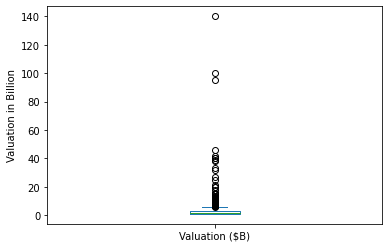

In [92]:
print("\n----------- Valuation ($B) -----------")
print("mean: ", df['Valuation ($B)'].mean())
print("median: ", df['Valuation ($B)'].median())
print("max: ", df['Valuation ($B)'].max())
print("min: ", df['Valuation ($B)'].min())
print("---------------------------------------")
df.dtypes
ax = df['Valuation ($B)'].plot(x='class', kind='box')
ax.set_ylabel("Valuation in Billion")

After seeing the distribution of valuation column of the data set, we have decided to only take valuation up to 2 billion dollars. This is because there are some really big outliers in the dataset. For example, ByteDance has an evaluation fo $140 billions dollars, which is $40 billion higher than the second highest company. A company is consider a unicorn if it surpass $1 billion in valuation. Therefore more than 60% of the data set is within 1 - 2 billion dollars.

After removing outliers:  (645, 15)


Text(0.5, 0, 'Valuation ($B)')

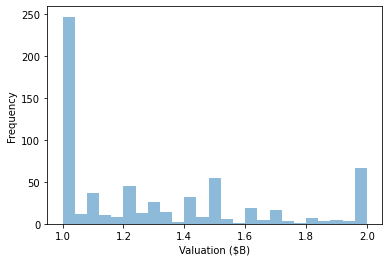

In [93]:
df = df[df['Valuation ($B)'] <= 2]
print("After removing outliers: ", df.shape)
ax = df['Valuation ($B)'].plot.hist(bins=25, alpha=0.5)
ax.set_xlabel("Valuation ($B)")

now we can look at other catergories, starting with investors count.


----------- Investors Count -----------
mean:  12.655813953488373
median:  11.0
max:  91
min:  0
---------------------------------------


Text(0, 0.5, 'Count')

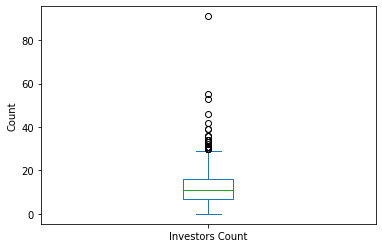

In [94]:
print("\n----------- Investors Count -----------")
print("mean: ",df['Investors Count'].mean())
print("median: ",df['Investors Count'].median())
print("max: ",df['Investors Count'].max())
print("min: ",df['Investors Count'].min())
print("---------------------------------------")

ax = df['Investors Count'].plot(x='class', kind='box')
ax.set_ylabel("Count")

Similar to valuation column, the investor count has a lot of outliers. Therefore we have decided to remove these outliers by taking data set within the boxplot whiskers. After removing the outliers, we can see that the dataset is not so skewed like before.

upper whisker:  29.5


Text(0, 0.5, 'Count')

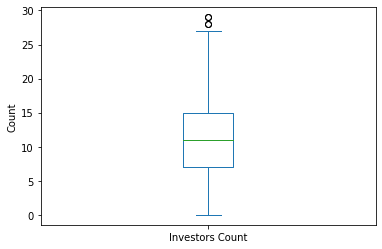

In [95]:
whisker = 1.5 * (df['Investors Count'].quantile(.75) - df['Investors Count'].quantile(.25))
whisker += df['Investors Count'].quantile(.75)
print("upper whisker: ", whisker)
# here we've adjusted the number of investors we accept
df = df[df['Investors Count'] <= 29.5]
ax = df['Investors Count'].plot(x='class', kind='box')
ax.set_ylabel("Count")

Now we check the year that the company was founded.


-----------Founded Year-----------
mean:  1908.6763754045307
median:  2014.0
max:  2021
min:  0
---------------------------------------


Text(0, 0.5, 'Year')

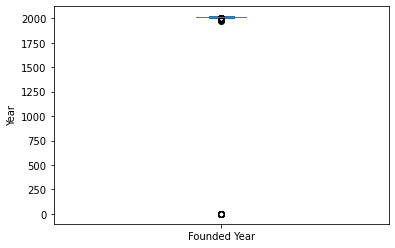

In [96]:
print("\n-----------Founded Year-----------")
print("mean: ",df['Founded Year'].mean())
print("median: ",df['Founded Year'].median())
print("max: ",df['Founded Year'].max())
print("min: ",df['Founded Year'].min())
print("---------------------------------------")

ax = df['Founded Year'].plot(x='class', kind='box')
ax.set_ylabel("Year")

In the year founded column, there is a missing entry where it is zero. Most of the companies are in the 2000s. Therefore this one entry made the mean to be in 1900s. We have decided to remove outliers by taking dataset only within the interquartile range.

whisker_upper:  2025.0
whisker_lower:  2001.0


Text(0, 0.5, 'Year')

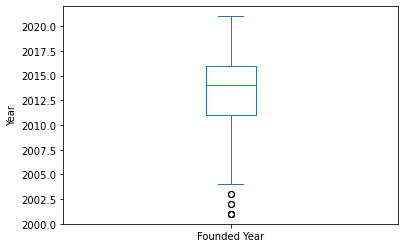

In [97]:
# Note: after seeing the boxplot, we decided to take up to the maximum in whisker boxplot
IQR = 1.5 * (df['Founded Year'].quantile(.75) - df['Founded Year'].quantile(.25))
whisker_upper = df['Founded Year'].quantile(.75) + IQR
whisker_lower = df['Founded Year'].quantile(.25) - IQR

print("whisker_upper: ", whisker_upper)
print("whisker_lower: ", whisker_lower)
df = df[df['Founded Year'] <= whisker_upper]
df = df[df['Founded Year'] >= whisker_lower]

ax = df['Founded Year'].plot(x='class', kind='box')
ax.set_ylabel("Year")

Text(0.5, 0, 'Mean Valuation ($B)')

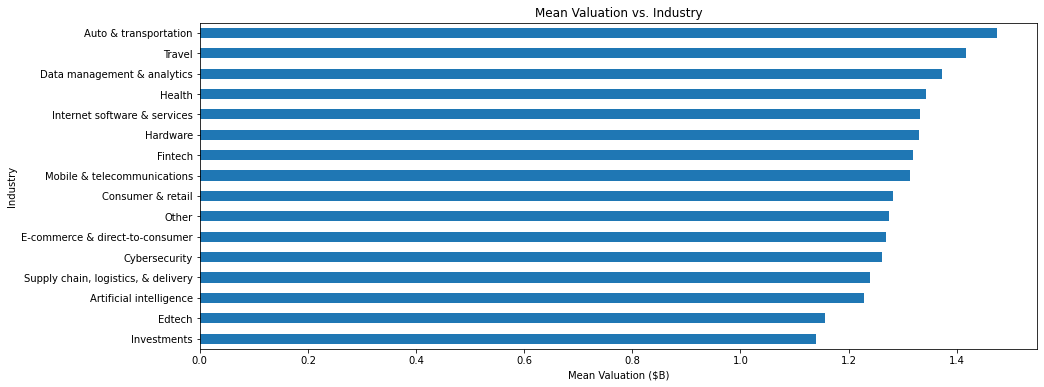

In [98]:
# examine the relationship between valuation vs industry
ax = df.groupby(['Industry'])['Valuation ($B)'].mean().sort_values().plot.barh(figsize=(15,6))
ax.set_title('Mean Valuation vs. Industry')
ax.set_xlabel("Mean Valuation ($B)")

Text(0.5, 0, 'Mean Valuation ($B)')

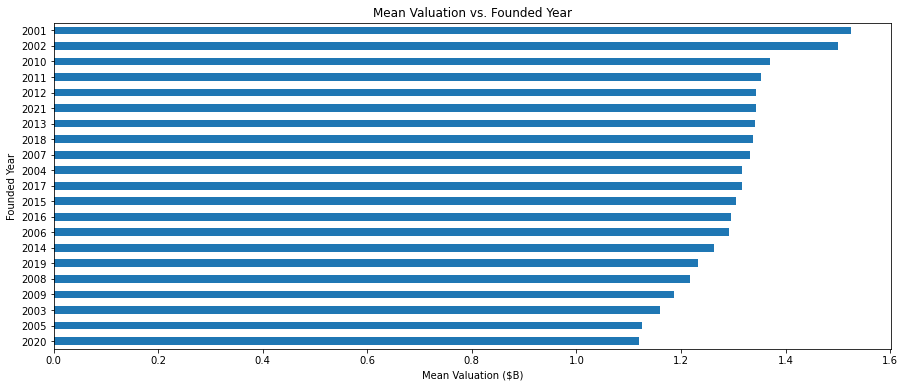

In [99]:
# examine the relationship between valuation vs founded year
ax = df.groupby(['Founded Year'])['Valuation ($B)'].mean().sort_values().plot.barh(figsize=(15,6))
ax.set_title('Mean Valuation vs. Founded Year')
ax.set_xlabel("Mean Valuation ($B)")

Text(0.5, 0, 'Mean Valuation ($B)')

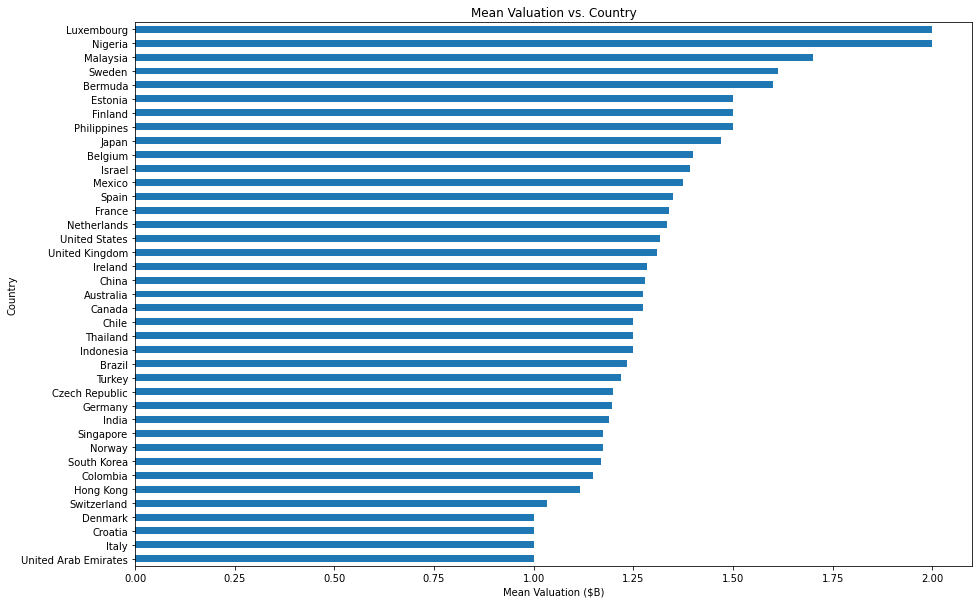

In [100]:
# examine the relationship between valuation vs country
ax = df.groupby(['Country'])['Valuation ($B)'].mean().sort_values().plot.barh(figsize=(15,10))
ax.set_title('Mean Valuation vs. Country')
ax.set_xlabel("Mean Valuation ($B)")

In [101]:
# We have also decided to normalized the 'Total Raised ($M)' column to 
# make sure that the distance won't effect our model prediction.

# normalizing numeric columns
df['Total Raised ($M)'] = (df['Total Raised ($M)'] - df['Total Raised ($M)'].min()) / (df['Total Raised ($M)'].max() - df['Total Raised ($M)'].min())

# Feature Engineering
Here, we perform one-hot encoding for categorical variables, binning for valuation, and drop attributes that aren't significant.


In [102]:
# one-hot encoding categorical variables
one_country = pd.get_dummies(df["Country"], prefix="Country")
df = df.join(one_country)

one_industry = pd.get_dummies(df["Industry"], prefix="Industry")
df = df.join(one_industry)

one_stage = pd.get_dummies(df["Financial Stage"], prefix="Financial Stage")
df = df.join(one_stage)

# remove the originals after making the one-hot-encoding
df = df.drop(['Country'], axis = 1)
df = df.drop(['Industry'], axis = 1)
df = df.drop(['Financial Stage'], axis = 1)

df.head()

,Company,Valuation ($B),City,Select Inverstors,Founded Year,Investors Count,Deal Terms,Portfolio Exits,Month Joined,Day Joined,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,Xinchao Media,2.0,Chengdu,"JD.com, Baidu, Vision Plus Capital",2007,8,4,1,4,9,...,0,0,0,0,0,0,0,1,0,0
392,BlaBlaCar,2.0,Paris,"Accel Partners, Index Ventures, Insight Ventur...",2006,13,6,0,9,16,...,0,0,0,0,0,0,0,0,1,0
393,HuiMin,2.0,Beijing,"Zheshang Venture Capital, GP Capital, Western ...",2013,13,1,0,9,5,...,0,0,0,0,0,0,0,0,1,0
394,Quora,2.0,Mountain View,"Y Combinator, Matrix Partners, Benchmark",2009,10,5,0,4,21,...,0,0,0,0,0,0,0,0,1,0
395,Improbable,2.0,London,"Andreessen Horowitz, SoftBank Group, Temasek H...",2012,7,4,0,5,11,...,1,0,0,0,0,0,0,0,1,0


In [103]:
# after looking at the data set, we decided to remove several attributes that don't appear to be significant.
df = df.drop(['City'], axis = 1)
df = df.drop(['Select Inverstors'], axis = 1)
df = df.drop(['Month Joined'], axis = 1)
df = df.drop(['Day Joined'], axis = 1)
df = df.drop(['Company'], axis = 1)

# here, we remove entries with 0 for founded year and year joined
df = df[df['Founded Year'] != 0]
df = df[df['Year Joined'] != 0]

# here we create a new feature: time to become a unicorn company: year joined - founded year
df['Time til Unicorn'] = df['Year Joined'] - df['Founded Year']
df = df.drop(['Founded Year'], axis = 1)
df = df.drop(['Year Joined'], axis = 1)

In [104]:
# move 'Time til Unicorn' closer to the front (so that we can view it easier)
unicorn_time = df.pop('Time til Unicorn')
df.insert(3, 'Time til Unicorn', unicorn_time)

df.head()

,Valuation ($B),Investors Count,Deal Terms,Time til Unicorn,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,Country_Brazil,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,2.0,8,4,11,1,0.381745,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
392,2.0,13,6,9,0,0.161969,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
393,2.0,13,1,3,0,0.149148,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
394,2.0,10,5,8,0,0.082090,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
395,2.0,7,4,5,0,0.173344,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [105]:
# here we bin valuation, the variable we're predicting, because it is a continuous variable
# currently, the values range from [1, 2], and we bin them into 7 bins
num_bins = 7
valuation_min = df['Valuation ($B)'].min()
df['Valuation Bins'] = np.floor(((df['Valuation ($B)'] - valuation_min) * num_bins))
df = df.drop(['Valuation ($B)'], axis = 1)
df.head()

,Investors Count,Deal Terms,Time til Unicorn,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,Country_Brazil,Country_Canada,...,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse,Valuation Bins
319,8,4,11,1,0.381745,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7.0
392,13,6,9,0,0.161969,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0
393,13,1,3,0,0.149148,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0
394,10,5,8,0,0.082090,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0
395,7,4,5,0,0.173344,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0


In [106]:
# move 'Valuation Bins' closer to the front (for easier readability)
val_bin = df.pop('Valuation Bins')
df.insert(1, 'Valuation Bins', val_bin)

df.head()

,Investors Count,Valuation Bins,Deal Terms,Time til Unicorn,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,Country_Brazil,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,8,7.0,4,11,1,0.381745,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
392,13,7.0,6,9,0,0.161969,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
393,13,7.0,1,3,0,0.149148,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
394,10,7.0,5,8,0,0.082090,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
395,7,7.0,4,5,0,0.173344,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [107]:
# check the Valuation Bins that was created
df['Valuation Bins'].value_counts()

0.0    257
1.0     66
3.0     64
2.0     63
7.0     59
4.0     35
5.0     12
6.0      6
Name: Valuation Bins, dtype: int64

# 	Data Analysis:
We try a variety of different models and hyperparameter tuning methods, including:
* KNN
* Naive Bayes
* Decision Tree
* Neural Nets
* Random Forest
* AdaBoost (ensemble)

In [108]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline
# imbalanced learning
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

In [109]:
# creating training and test set
labels = df['Valuation Bins'].values.ravel()
features = df.drop(['Valuation Bins'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# 	K-Nearest Neighbors

In [110]:
# creating objects
pca = PCA()
# we used a RandomOverSampler to mitigate the class imbalance issue
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=0)
knn = KNeighborsClassifier(n_neighbors=2)
scaler = StandardScaler()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('randomoversampler', ros),\
                                               ('sampling', smote),('knn', knn)])

# cross validation
nested_score = cross_val_score(pipeline, x_train, y_train, cv=5)

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

# checking accuracy
print(classification_report(y_test, y_pred))
print("Validation Accuracy:", nested_score.mean()*100)

              precision    recall  f1-score   support

         0.0       0.48      0.42      0.44        53
         1.0       0.06      0.07      0.06        14
         2.0       0.00      0.00      0.00        11
         3.0       0.06      0.08      0.07        13
         4.0       0.00      0.00      0.00         5
         5.0       0.00      0.00      0.00         4
         6.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00        12

    accuracy                           0.21       113
   macro avg       0.07      0.07      0.07       113
weighted avg       0.24      0.21      0.22       113

Validation Accuracy: 27.17353308364544


In [111]:
# print(pipeline.get_params().keys())
param_grid = {
    'pca__n_components': list(range(5, 68)),
    'knn__n_neighbors': list(range(1, 10))
}

# grid_search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
# best outcomes
print("Best params: ", grid_search.best_params_)
print("Grid Search Accuracy: ", grid_search.best_score_*100)

Best params:  {'knn__n_neighbors': 1, 'pca__n_components': 10}
Grid Search Accuracy:  30.511860174781525


# 	Naive Bayes

In [113]:
# imports
from sklearn.naive_bayes import GaussianNB

# creating model
model = GaussianNB()
model.fit(x_train, y_train)
# cross validation
nested_score = cross_val_score(model, x_train, y_train, cv=10)

print("Validation Accuracy:", nested_score.mean()*100)

# imports
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

y_pred = cross_val_predict(model, x_test, y_test, cv=10)
matrix = confusion_matrix(y_test, y_pred)
print('------ Confusion Matrix ------')
print(matrix)
print('------------------------------')
print(classification_report(y_test, y_pred))

Validation Accuracy: 5.5606060606060606
------ Confusion Matrix ------
[[14 14  7  2  7  0  0  4]
 [ 1 12  1  0  1  0  0  1]
 [ 2  6  0  2  1  0  0  1]
 [ 1 12  2  2  1  0  0  2]
 [ 0  2  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 2  5  2  0  2  0  0  2]]
------------------------------
              precision    recall  f1-score   support

         0.0       0.70      0.29      0.41        48
         1.0       0.23      0.75      0.35        16
         2.0       0.00      0.00      0.00        12
         3.0       0.33      0.10      0.15        20
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1
         7.0       0.20      0.15      0.17        13

    accuracy                           0.27       113
   macro avg       0.18      0.16      0.14       113
weighted avg       0.41      0.27      0.27       113



C:\Users\tuani\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

# 	Decision Tree

In [112]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
model = DecisionTreeClassifier(criterion='entropy')
# param options
params = {"max_depth": list(range(5, 21)), 
         "min_samples_leaf": list(range(5, 21)),
         "max_features": list(range(5, 21))}

# create and fit the GridSearchCV object
grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print("Grid Search Accuracy:", grid_search.best_score_*100)

nested_score = cross_val_score(grid_search, x_train, y_train, cv=10)
print("Validation Accuracy:", nested_score.mean()*100)

KeyboardInterrupt: 

# 	Neural Nets

In [ ]:
# imports
from sklearn.neural_network import MLPClassifier

# create the model
scaler = StandardScaler()
nn = MLPClassifier()
pipeline = Pipeline(steps=[('scaler', scaler), ('nn', nn),])

# hyperparameter tuning
param_grid = {
    'nn__hidden_layer_sizes': list(range(30, 61, 10)),
    'nn__activation': ['logistic', 'tanh', 'relu']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# checking accuracy
print(grid_search.best_params_)
print("Grid Search Accuracy: ", grid_search.best_score_*100)

nested_score = cross_val_score(grid_search, x_train, y_train, cv=10)
print("Validation Accuracy: ", nested_score.mean()*100)

C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multi

{'nn__activation': 'logistic', 'nn__hidden_layer_sizes': 40}
Grid Search Accuracy: 39.20848938826467


C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Validation Accuracy: 43.20202020202021


C:\Users\tuani\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 	Random Forest

In [ ]:
# imports
from sklearn.ensemble import RandomForestClassifier

# create the model
model = RandomForestClassifier()

# hyper parameter tuning
param_grid = {
    'max_depth': list(range(35, 46)),
    'min_samples_leaf': list(range(8, 13, 2)),
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# checking accuracy
print(grid_search.best_params_)
print("Grid Search Accuracy: ", grid_search.best_score_*100)

nested_score = cross_val_score(grid_search, x_train, y_train, cv=10)
print("Validation Accuracy: ", nested_score.mean()*100)

{'max_depth': 35, 'max_features': 'sqrt', 'min_samples_leaf': 8}
Grid Search Accuracy: 44.7665418227216


C:\Users\tuani\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Validation Accuracy: 44.76767676767676


In [ ]:
# ----- AdaBoost (ensemble) ----- 
# imports
from sklearn.ensemble import AdaBoostClassifier

# build and fit the model
model = AdaBoostClassifier(n_estimators=150)
model.fit(x_train, y_train)

# checking the accuracy
scores = cross_val_score(model, x_train, y_train, cv=5) 
print('Validation Accuracy: %.3f ' % (np.mean(scores) * 100))

Accuracy: 35.156 


# 	Outcome / Results: 
Based on our results, we found that the models with the highest accuracy were decision trees and random forest. Since our dataset contained many categorical attributes that needed to be one-hot encoding, this makes sense. Models that relied on calculating distance would have a lower accuracy taking this into account.

Validation Accuary Summary:
* KNN  --  26%
* Naive Bayes  --  27%
* Decision Tree  --  44%
* Neural Nets  --  44%
* Random Forest  --  43%
* AdaBoost (ensemble)  --  35%

note: some of these accuaries may change due to randomness



How can we improve?? more data, more time, ... older startup??

In [ ]:
How can we use new data to update/validate the model??

In [ ]:
Maybe some prediction examples?